# An intro to GANs with Tensorflow

## GAN's Architecture

<img src='images/gan_basic.png' alt='GAN basic architecture'>

- **The Discriminator ($D$):** The Discriminator is also a neural network. It's input is either a 'real' image from the dataset or a 'fake' one generated by the Generator. Its output is a boolean variable which is basically a decision on whether the input image is real or fake.

- **The Generator ($G$):** The Generator is a neural network that takes a randomly generated vector as input and generates an output image. This image is called the 'fake' image and has the same dimensions as a 'real' image taken from the dataset.


Since both $D$ and $G$ are neural networks, they need to be trained. However, they have different training objectives. Let's put it this way: $D$ seeks the truth, if the input image is real, its training objective would be to output the 'real' label. If the input image is a 'fake' one generated by $G$, its training label would be 'fake'. $G$, on the other hand, seeks to cheat $D$ by thinking that a fake image is a real one. This means that the training objective for $G$ is to make $D$ output the 'real' label each time a 'fake' image is presented. 

This means that we have three types of training examples in a GAN:

1. **Type 1** is used to train $D$. It consists of *(real image, real label)* pairs.

2. **Type 2** is also used to train $D$. It consists of *(fake image, fake label)* pairs.

3. **Type 3** is used to train $G$ while $D$ parameters are fixed. It consists of *(fake_image, real label)* pairs.

## The Discriminator (D)

The discriminator is a Convolutional Neural Network (CNN) as shown in the below figure. It takes an input image and decides whether it is real (1) or fake (0). Input images to $D$ come either from the data set of real images, or from the output of the generator $G$ as fake_images. Here are the main operation needed to build $D$:

<img src='images/discriminator.png' alt='discriminator architecture'>



- **Convolution:**: This is a linear operation that can be viewed as a pattern detector. Tensorflow provides the <a href='https://www.tensorflow.org/api_docs/python/tf/layers/conv2d'>`tf.layers.conv2d()`</a> to easily implement this operation.


- **Batch normalizatioin:** In the original <a href="https://arxiv.org/pdf/1511.06434.pdf">DCGAN paper</a>, Batch Normalization (BN) was shown to give better results while making training easier. The easiest way to implement BN is tensorflow is by using <a href='https://www.tensorflow.org/api_docs/python/tf/layers/batch_normalization'>`tf.layers.batch_normalization()`</a>.


- **LReLU:** Leaky Rectified Linear Unit (LReLU) is a non-linear function that makes training easier by preventing vanishing gradients. An easy way to implement an LReLU is by using the <a href = 'https://www.tensorflow.org/api_docs/python/tf/maximum'>`tf.maximum()`</a> function.


- **Flattening:** Since the input to G is a vector (or a 1D tensor) and the output is an image (3D tensor). A reshape operation is necessary at some point to convert from a 1D to a 3D tensor. This can be done in tensorflow using <a href='https://www.tensorflow.org/api_docs/python/tf/reshape'>`tf.reshape()`</a>.


- **Dense transformation:** This is a linear operation accomplished by means of fully-connected layer which connects all input units to all output units. This is necessary in order to transform the flattened output of the last convolutional layer into a single value representing the output logit of the network. One way to apply this is by using the <a href='https://www.tensorflow.org/api_docs/python/tf/layers/dense'>`tf.layers.dense()`</a> function.


- **Sigmoid:** This non-linear function is applied on the output logit on the network to obtain a value between 0 and 1 representing the final decision of the network. In Tensorflow we can use the <a href='https://www.tensorflow.org/api_docs/python/tf/sigmoid'>`tf.nn.sigmoid()`</a> function.

Before starting to implementing the discriminator, lest's start by importing some packages that we will need later

In [1]:
import tensorflow as tf
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

Now here is a tensorflow implenetation of the discriminator network shown above:

In [2]:
def discriminator(images, reuse = False, training = True):
    """
    Create the discriminator neural network (D)
    
    parameters
    -----------
    :images: tensor or tensor placeholder (batch_size, 32, 32, 3)
             a batch of input images.
               
    :reuse: boolean
            should be set as True when network parameters should be reused, False otherwise.
            
    :training: boolean
            should be set as True during the training phase, False otherwise.
               
    returns
    -------
    :outputs: tensor (batch_size, 1)
              a batch of the generated 'fake' images.
    """

    # This is the leak parameter for the LReLU
    alpha = 0.1

    with tf.variable_scope('D', reuse = reuse):
        
        ## Layer 1
        ## Input:  images, with size (batch_size, 32, 32, 3)
        ## Output: relu1, with size (batch_size, 32, 32, 32)
        
        x1 = tf.layers.conv2d(inputs = images, 
                              filters = 32, kernel_size = 3, strides = 1, use_bias = True, padding = 'same')
        relu1 = tf.maximum(alpha * x1, x1)
        
        ## Layer 2
        ## Input:  relu1, with size (batch_size, 32, 32, 32)
        ## Output: relu2, with size (batch_size, 16, 16, 64)
        
        x2 = tf.layers.conv2d(inputs = relu1, 
                              filters = 64, kernel_size = 5, strides = 2, use_bias = False, padding = 'same')
        bn2 = tf.layers.batch_normalization(inputs = x2, training = training)
        relu2 = tf.maximum(alpha * bn2, bn2)
        
        ## Layer 3
        ## Input:  relu2, with size (batch_size, 16, 16, 64)
        ## Output: relu3, with size (batch_size, 8, 8, 128)
        
        x3 = tf.layers.conv2d(inputs = relu2, 
                              filters = 128, kernel_size = 5, strides = 2, use_bias = False, padding = 'same')
        bn3 = tf.layers.batch_normalization(inputs = x3, training = training)
        relu3 = tf.maximum(alpha * bn3, bn3)
        
        ## Layer 4
        ## Input:  relu3, with size (batch_size, 8, 8, 128)
        ## Output: relu4_flat, with size (batch_size, 4 * 4 * 256)
        
        x4 = tf.layers.conv2d(inputs = relu3, 
                              filters = 256, kernel_size = 5, strides = 2, use_bias = False, padding = 'same')
        bn4 = tf.layers.batch_normalization(inputs = x4, training = training)
        relu4 = tf.maximum(alpha * bn4, bn4)
        relu4_flat = tf.reshape(tensor = relu4, shape = (-1,  np.prod(relu4.get_shape().as_list()[1:])))

                
        ## Layer 5
        ## Input:  relu4_flat, with size (batch_size, 4 * 4 * 256)
        ## Output: outputs, with size (batch_size, 1)
        
        logits = tf.layers.dense(inputs = relu4_flat, units = 1) 
        outputs = tf.nn.sigmoid(logits)

        return logits, outputs

## The Generator (G)

The Generator takes an input as a randomly generated low-dimensional vector, and produces an output image that has the same dimensions as real images in the dataset. This transoformation is carried out throughout multiple layers. At each layers, one or more of the following operations are performed:

- **Reshape:** Since the input to G is a vector (or a 1D tensor) and the output is an image (3D tensor). A reshape operation is necessary at some point to convert from a 1D to a 3D tensor. This can be done in tensorflow using <a href='https://www.tensorflow.org/api_docs/python/tf/reshape'>`tf.reshape()`</a>.


- **Pattern generation:** The main operation used in a G to generate image patterns is deconvolution. While a convolution kernel is used to encode an input image patch into a single pixel of the output image, deconvolution can be used to do just the opposite; decode a single pixel from the input image into an output image patch or pattern. In Tensorflow, a similar operation can be applied using a transposed convolution by means of the <a href='https://www.tensorflow.org/api_docs/python/tf/layers/conv2d_transpose'>`tf.layers.conv2d_transpose()`</a> function.


- **Upsampling:** In the same way as convolution can be used to downsample an image (or tensor) using a stride higher than a $1$. Deconvolution can be used to upsample an image by also using a stride higher than $1$. Upsampling is needed since tensors have lower height/width earlier in the generator's pipeline and get a higher height/width in later layers. 


- **Linear transformation:** The linear transformation we need to apply in the generator is carried out by a dense (fully-connected) layer. This is necessary in order to transform the input random vector into a new vector with a size more adapted to the reshaping operation. One way to apply this is by using the <a href='https://www.tensorflow.org/api_docs/python/tf/layers/dense'>`tf.layers.dense()`</a> function.


- **Non-linear transformation:** The applied non-linearity is a Leaky Rectified Linear Unit (LReLU) which makes training easier. An easy way to implement an LReLU is by using the <a href = 'https://www.tensorflow.org/api_docs/python/tf/maximum'>`tf.maximum()`</a> function.


- **Batch-normalizatioin:** In the original <a href="https://arxiv.org/pdf/1511.06434.pdf">DCGAN paper</a>, Batch Normalization (BN) was shown to give better results while making training easier. The easiest way to implement BN is tensorflow is by using <a href='https://www.tensorflow.org/api_docs/python/tf/layers/batch_normalization'>`tf.layers.batch_normalization()`</a>.

So let's use Tensorflow to build a generator with an architecture as in the figure below:

<img src='images/generator.png' alt='generator architecture'>



In [3]:
def generator(z_, reuse = False, training = True):
    """
    Create the generator neural network (G)
    
    parameters
    -----------
    :z: tensor placeholder (batch_size, z_size)
        a batch of randomly generated vectors.
               
    :reuse: boolean
            should be set as True when network parameters should be reused, False otherwise.
            
    :training: boolean
            should be set as True during the training phase, False otherwise.
               
    returns
    -------
    :fake_images: tensor (batch_size, 32, 32, 3)
                 a batch of the generated 'fake' images.
    """
    
    
    # This is the leak parameter for the LReLU
    alpha = 0.1
    
    # All generator parameters are defined inside the 'G' scope
    with tf.variable_scope('G', reuse = reuse):
        
        ## Layer 1
        ## Input:  z, with size (batch_size, z_size)
        ## Output: relu1, with size (batch_size, 4, 4, 1024)
        x1 = tf.layers.dense(inputs = z_, 
                             units = 4 * 4 * 1024, use_bias = False) 
        x1 = tf.reshape(tensor = x1, shape = [-1, 4, 4, 1024]) # Reshape operation
        bn1 = tf.layers.batch_normalization(inputs = x1, training = training) # Batch normalization
        relu1 = tf.maximum(alpha * bn1, bn1) # Leaky ReLU
        
        ## Layer 2
        ## Input: relu1, with size (batch_size, 4, 4, 1024)
        ## Output: relu2, with size (batch_size, 8, 8, 512)
        
        # Transposed convolution, resulting size of x2 is (batch_size, 8, 8, 512)
        x2 = tf.layers.conv2d_transpose(inputs = relu1, 
                                        filters = 512, kernel_size = 3, strides = 2, padding = 'same', use_bias = False)
        
        bn2 = tf.layers.batch_normalization(inputs = x2, training = training)
        relu2 = tf.maximum(alpha * bn2, bn2)
        
        ## Layer 3
        ## Input: relu2, with size (batch_size, 8, 8, 512)
        ## Output: relu3, with size (batch_size, 16, 16, 256)
        
        x3 = tf.layers.conv2d_transpose(inputs = relu2, 
                                        filters = 265, kernel_size = 5, strides = 2, padding = 'same', use_bias = False)
        bn3 = tf.layers.batch_normalization(inputs = x3, training = training)
        relu3 = tf.maximum(alpha * bn3, bn3)
        
        ## Layer 4
        ## Input: relu3, with size (batch_size, 16, 16, 256)
        ## Output: relu4, with size (batch_size, 16, 16, 128)
        
        x4 = tf.layers.conv2d_transpose(inputs = relu3, 
                                        filters = 128, kernel_size = 5, strides = 1, padding = 'same', use_bias = False)
        bn4 = tf.layers.batch_normalization(inputs = x4, training = training)
        relu4 = tf.maximum(alpha * bn4, bn4)
        
        ## Layer 5
        ## Input: relu4, with size (batch_size, 16, 16, 128)
        ## Output: relu5, with size (batch_size, 32, 32, 64)
        
        x5 = tf.layers.conv2d_transpose(inputs = relu4, 
                                        filters = 64, kernel_size = 5, strides = 2, padding = 'same', use_bias = False)
        bn5 = tf.layers.batch_normalization(inputs = x5, training = training)
        relu5 = tf.maximum(alpha * bn5, bn5)
        
        ## Layer 6
        ## Input: relu5, with size (batch_size, 32, 32, 64)
        ## Output: fake_images, with size (batch_size, 32, 32, 3)
        
        x6 = tf.layers.conv2d_transpose(inputs = relu5, 
                                        filters = 3, kernel_size = 5, strides = 1, padding = 'same', use_bias = False)


        # Apply tanh activation function to get output values between -0.5 and +0.5
        fake_images = tf.nn.tanh(x6) * 0.5
        
        return fake_images

Notice that no batch normalization is applied to the output layer as recommended in the <a href="https://arxiv.org/pdf/1511.06434.pdf">DCGAN paper</a> to avoid instability in training. Moreover, the non-linear activation function used in the output is a `tanh` rather than a `LReLU` which is required to keep pixel values in the generated image between -1 and +1 as in real images. 

You might have wondered about how the transposed convolution parameters such as the kernel size, strides and padding should be fixed in order to obtain the required output height and width. One way to do that is by choosing these parameters to be the same as those of a convolution operation that, if applied to a tensor  with the same height/width as the transposed convolution's output, would give a tensor that has the same height/width as the transposed convolution's input. If you wish to learn more about transposed convolution, you can check <a href="http://deeplearning.net/software/theano_versions/dev/tutorial/conv_arithmetic.html#transposed-convolution-arithmetic">this page</a>.

In [4]:
def getPlaceholders(image_height, image_width, z_size):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """

    real_images_ = tf.placeholder(dtype = tf.float32, 
                                  shape = (None, image_height, image_width, 3),
                                  name = 'real_images')
    
    z_ = tf.placeholder(dtype = tf.float32, 
                              shape = (None, z_size),
                              name = 'z')
    
    
    return real_images_, z_

## Computing loss

In order to compute the Discriminator's loss, we need to compare its output value, to its desired output value; for real images, D's desired output is 1 and for fake ones, it is 0. To be more precise, instead of using a value of 1 to represent 'real', we would smooth this value by mutliplying it by a number slightly lower that 1. This was found to make training faster in the <a href="https://arxiv.org/pdf/1511.06434.pdf">DCGAN paper</a>.

To compute the Generator's loss, we should compare D's output to G's desired output which is a smoothed 1. Remember that the goal of the Generator is to trick the Discriminator into believing that fake images are real.

Computing this losses is performed according to a few train_steps shown in comments in the code below:

In [5]:
def getLoss(z_, real_images_):
    
    # This is the smoothing parameter
    smoothing = 0.9
    
    ## train_step 1: create and run the generator
    
    # get fake images from the generator
    fake_images = generator(z_ = z_, reuse = False, training = True)
    
    
    ## train_step 2: create and run the discriminator
    
    # get final outputs from the discriminator which are 'real' or 'fake' decisions
    d_output_real, d_logits_real = discriminator(images = real_images_, reuse = False, training = True)
    d_output_fake, d_logits_fake = discriminator(images = fake_images,  reuse = True, training = True)
    
    
    ## train_step 3: compute training losses for both D and G
    
    # create desired labels for real and fake images
    labels_real = tf.ones_like(d_logits_fake) * smoothing
    labels_fake = tf.zeros_like(d_logits_fake)
    
    # compute the generator's loss by comparing the discriminator's outputs to the
    # generator's desired outputs
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits = d_logits_fake, labels = labels_real))
    
    # Compute the discriminator's loss by comparing the discriminator's outputs to the
    # discriminators's desired outputs
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits = d_logits_real, labels = labels_real))
    
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits = d_logits_fake, labels = labels_fake))
    
    # The total loss for the discriminator is the sum of losses on fake and real images
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss

Notice in line 16 that we set the 'reuse' argument to True. This is important since this is the second call to the `discriminator()` function and we do not wish to create a new discriminator with new parameters. We need to use the already created discriminator in line 15.

## Setting up the optimizers

Tensorflow provides a bunch of optimizers that can be used out-of-the-box. These optimizers automatically minimize the loss by computing gradients and modifying the network parameters. For our model we are going to use the Adam optimizer (<a href='https://www.tensorflow.org/api_docs/python/tf/train/AdamOptimizer'>tf.train.AdamOptimizer</a>). For a comparision among different optimizers, you can go ahead and check <a href='http://ruder.io/deep-learning-optimization-2017/'>this great post</a>.

Notice that parameters for $D$ and $G$ are not modified simultaneously. Each one of them has its own trainable parameters that need to be modified while the other's are fixed. Thus, we need two optimizers; one for $D$ and another of $G$.

Since we are using batch normalization in both $D$ and $G$, we need to add the line 

`with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):` 

before implementing the optimizers. This tells Tensorflow that updating the moving averages for means and variances necessary for batch normalization should take place before executing the training train_step. Here is <a href='http://python.usyiyi.cn/documents/effective-tf/7.html'>a nice article</a> that explains the idea behind control dependencies.

In [6]:
def getOptimizers(d_loss, g_loss, learning_rate, beta1):


    # get the list of trainable parameters of the network.
    # trainable names defined inside the 'G' variable scope start with the string 'G'
    # trainable names defined inside the 'D' variable scope start with the string 'D'
    trainables = tf.trainable_variables()
 
    # separate trainable parameters of the discriminator from those of the generator
    d_vars = [var for var in trainables if var.name.startswith('D')]
    g_vars = [var for var in trainables if var.name.startswith('G')]

    # create two optimizers. For each one, inject the corresponding loss
    # to be minimized and which network parameters to tune
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        
        d_opt = tf.train.AdamOptimizer(learning_rate = learning_rate, 
                                       beta1 = beta1).minimize(d_loss, var_list = d_vars)
        
        g_opt = tf.train.AdamOptimizer(learning_rate = learning_rate, 
                                       beta1 = beta1).minimize(g_loss, var_list = g_vars)
    
    return d_opt, g_opt

In [7]:

class Helper:
    
    def configDataset(self, data_path, batch_size, image_height, image_width):
        """ 
            sets some instance variables to handle the dataset and batches.
        """
        self.data_path = 'data/celeba/'
        self.batch_size = batch_size
        self.image_height = image_height
        self.image_width = image_width    

    def getImage(self, image_path):

        # load the image
        image = cv2.imread(image_path)

        # convert the image to RGB. This is because opencv load images in BGR by default
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # crop the image to a little square area just around the face. 
        # This is to make training faster and easier
        area_size = 120
        x = (image.shape[0] - area_size ) // 2
        y = (image.shape[1] - area_size ) // 2
        image = image [x : x + area_size, y : y + area_size]


        # resize the image
        image = cv2.resize(image, (self.image_width, self.image_height))
        #plt.imshow(image)
        #plt.show()

        # normalize pixel values to the range [-0.5, 0.5]
        image = (image / 255) - 0.5

        return image

    def getBatch(self):

        # get a list of all image names in the dataset
        all_names = os.listdir(self.data_path)

        # index of the an image in image_names
        index = 0

        while index < len(all_names):

            # get a list of image name to put in the batch
            batch_names = all_names[index : index + self.batch_size]


            # create the batch: a numpy array containing images
            image_batch = np.array(
                [self.getImage(os.path.join(self.data_path, name)) for name in batch_names ]).astype(np.float32)


            # update the image index
            index += self.batch_size


            yield image_batch
            
    def showBatch(self, image_batch, image_per_side):
        
        # get height and width of individual images
        image_height = image_batch.shape[1]
        image_width = image_batch.shape[2]
        
        # create the convas that will include the image grid
        canvas = np.zeros(( image_per_side * image_height, image_per_side * image_width, 3), dtype = np.float32)

        # this are row and column indexes for the canvas array
        x = 0
        y = 0
        
        # populate the convas with images from the batch
        for i in range(image_per_side ** 2):

            canvas[x : x + image_height, y : y + image_width] = image_batch[i]
            
            y += image_width
          
            if y >= image_per_side * image_width:

                y = 0
                x += image_height
   
        # since individual images has values in [-0.5, 0.5]. Rectify this to [0,1]
        canvas = (canvas + 0.5)
        
        # return the canvas
        return canvas
        
    def show_generator_output(self, sess, n_images, z_):
        """
        Show example output for the generator
        :param sess: TensorFlow session
        :param n_images: Number of Images to display
        :param input_z: Input Z Tensor
        :param out_channel_dim: The number of channels in the output image
        :param image_mode: The mode to use for images ("RGB" or "L")
        """

        z_size = z_.get_shape().as_list()[-1]
        z = np.random.uniform(-1, 1, size=[n_images, z_size])

        image_batch = sess.run(generator(z_, reuse = True, training = False),
                               feed_dict={z_: z})

        images_grid = self.showBatch(image_batch, int(np.sqrt(n_images)))
        plt.imshow(images_grid)
        plt.show()

## Setting up the training procedure

Setting up the training procedure is simple. We first need to create the network and get the losses using our `getLoss()` function. Then we use those losses to create the optimizers using the `getOptimizers()` function we defined earlier. Then we run these optimizers in each training step. Here is how to do that in more detail: 

In [8]:
def train(n_epochs, z_size, learning_rate, beta1, helper):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    

    # get input placeholders
    real_images_, z_ = getPlaceholders(image_height, image_width, z_size)
    
    # create the GAN network and get the losses
    d_loss, g_loss = getLoss(z_, real_images_)
    
    # create the optimizers by injecting the losses and other hyperparameters
    d_opt, g_opt = getOptimizers(d_loss, g_loss, learning_rate, beta1)
    
    
    with tf.Session() as sess:
        
        # initialize all 'tf.Variable' objects
        sess.run(tf.global_variables_initializer())
        
        # start going through epochs
        for ep in range(n_epochs):
            
            # a counter for training train_steps
            train_step = 0
            
            # get a batch of real images from the dataset
            for real_images in helper.getBatch():

                real_images *= 2
                
                train_step +=1
                
                # create a batch of random vectors 'z' as inputs to G
                z = np.random.uniform(low = -1, high = 1,size = [batch_size, z_size])
               
                # run an optimization train_step (training train_step) for each of G and D
                sess.run(d_opt, feed_dict = {z_ : z, real_images_ : real_images})
                sess.run(g_opt, feed_dict = {z_ : z, real_images_ : real_images})
                
                # this is just for visualization of training loss at the current training train_step
                if train_step % 25 == 0:
                    d_loss_train = d_loss.eval({z_: z, real_images_: real_images})
                    g_loss_train = g_loss.eval({z_: z, real_images_: real_images})
                    
                    print("Epoch {}/{}".format(ep + 1, n_epochs),
                          "D loss {:.8f} ...".format(d_loss_train),
                          "G loss {:.8f} ...".format(g_loss_train))
                    
                if train_step % 100 == 0:
                    helper.show_generator_output(sess, 100, z_)

## Training the GAN

First we need to fix some hyperparameters:

In [9]:
# the path to the folder containing face images
data_path = 'data/celeba/'

# number of epochs
n_epochs = 2

# the batch size used for training
batch_size = 25

# height and width of images
image_height = 32
image_width = 32

# parameters for the Adam optimizer
learning_rate = 0.0002
beta1 = 0.5

# size of random vectors used as input to the generators
z_size = 100

And finally we call the `train()` function we wrote earlier to launch the training procedure:

Epoch 1/2 D loss 1.72652364 ... G loss 0.41326168 ...
Epoch 1/2 D loss 1.72652364 ... G loss 0.41326168 ...
Epoch 1/2 D loss 1.72652364 ... G loss 0.41326168 ...
Epoch 1/2 D loss 1.72652769 ... G loss 0.41326168 ...


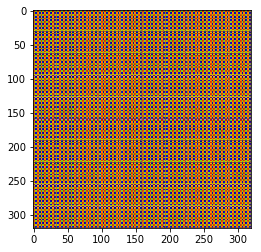

Epoch 1/2 D loss 1.72652364 ... G loss 0.41326168 ...
Epoch 1/2 D loss 1.72652435 ... G loss 0.41326168 ...
Epoch 1/2 D loss 1.72652364 ... G loss 0.41326168 ...
Epoch 1/2 D loss 1.72652352 ... G loss 0.41326168 ...


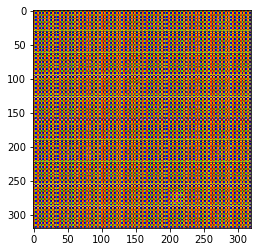

Epoch 1/2 D loss 1.72652352 ... G loss 0.41326168 ...


KeyboardInterrupt: 

In [10]:
# create a helper object that includes utility functions to get batches and 
# plot image grids
helper = Helper()
helper.configDataset(data_path, batch_size, image_height, image_width)

with tf.Graph().as_default():

    # start training ...
    train(n_epochs, z_size, learning_rate, beta1, helper)